## Objetivo

### Utilizando o dataset ["Fake News"](https://www.kaggle.com/datasets/rajatkumar30/fake-news) como base, o objetivo é treinar um modelo classificador de notícias entre reais e falsas.

In [65]:
import os
from pathlib import Path

iskaggle = os.environ.get('KAGGLE_KERNEL_RUN_TYPE', '')
if iskaggle: path = Path('../input/fake-news')
else:
    path = Path('fake-news')
    if not path.exists():
        import zipfile,kaggle
        kaggle.api.competition_download_cli(str(path))
        zipfile.ZipFile(f'{path}.zip').extractall(path)

In [66]:
import torch, numpy as np, pandas as pd
np.set_printoptions(linewidth=140)
torch.set_printoptions(linewidth=140, sci_mode=False, edgeitems=7)
pd.set_option('display.width', 140)

## Mostrando e ajustando dataset

### Exibindo o dataset original

In [67]:
df = pd.read_csv(path/'news.csv')
df

,Unnamed: 0,title,text,label
0,8476,You Can Smell Hillary’s Fear,"Daniel Greenfield, a Shillman Journalism Fello...",FAKE
1,10294,Watch The Exact Moment Paul Ryan Committed Pol...,Google Pinterest Digg Linkedin Reddit Stumbleu...,FAKE
2,3608,Kerry to go to Paris in gesture of sympathy,U.S. Secretary of State John F. Kerry said Mon...,REAL
3,10142,Bernie supporters on Twitter erupt in anger ag...,"— Kaydee King (@KaydeeKing) November 9, 2016 T...",FAKE
4,875,The Battle of New York: Why This Primary Matters,It's primary day in New York and front-runners...,REAL
...,...,...,...,...
6330,4490,State Department says it can't find emails fro...,The State Department told the Republican Natio...,REAL
6331,8062,The ‘P’ in PBS Should Stand for ‘Plutocratic’ ...,The ‘P’ in PBS Should Stand for ‘Plutocratic’ ...,FAKE
6332,8622,Anti-Trump Protesters Are Tools of the Oligarc...,Anti-Trump Protesters Are Tools of the Oligar...,FAKE
6333,4021,"In Ethiopia, Obama seeks progress on peace, se...","ADDIS ABABA, Ethiopia —President Obama convene...",REAL


### Verificando se tem algum valor nulo ou não preenchido

In [68]:
df.isna().sum()

Unnamed: 0    0
title         0
text          0
label         0
dtype: int64

### Descrevendo o dataset.

In [69]:
import numpy as np

df.describe(include=(np.number))

,Unnamed: 0
count,6335.000000
mean,5280.415627
std,3038.503953
min,2.000000
25%,2674.500000
50%,5271.000000
75%,7901.000000
max,10557.000000


### Verificando quantos dados tem de caba label (real ou falso).

Text(0, 0.5, 'Frequency')

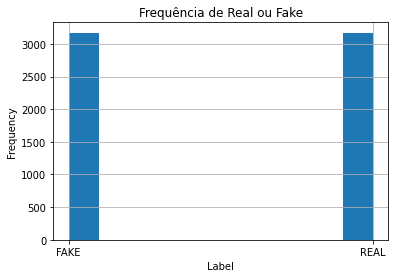

In [70]:
import matplotlib.pyplot as plt
df['label'].hist();
plt.title('Frequência de Real ou Fake')
plt.xlabel('Label')
plt.ylabel('Frequency')

### Mais uma descrição do dataset.

In [71]:
df.describe(include=[object])

,title,text,label
count,6335,6335,6335
unique,6256,6060,2
top,OnPolitics | 's politics blog,"Killing Obama administration rules, dismantlin...",REAL
freq,5,58,3171


### Transformar a label de REAL ou FAKE em 0 ou 1, real sendo 1 e fake sendo 0.

In [72]:
df['label'] = df['label'].map({'REAL': 1, 'FAKE': 0})
df

,Unnamed: 0,title,text,label
0,8476,You Can Smell Hillary’s Fear,"Daniel Greenfield, a Shillman Journalism Fello...",0
1,10294,Watch The Exact Moment Paul Ryan Committed Pol...,Google Pinterest Digg Linkedin Reddit Stumbleu...,0
2,3608,Kerry to go to Paris in gesture of sympathy,U.S. Secretary of State John F. Kerry said Mon...,1
3,10142,Bernie supporters on Twitter erupt in anger ag...,"— Kaydee King (@KaydeeKing) November 9, 2016 T...",0
4,875,The Battle of New York: Why This Primary Matters,It's primary day in New York and front-runners...,1
...,...,...,...,...
6330,4490,State Department says it can't find emails fro...,The State Department told the Republican Natio...,1
6331,8062,The ‘P’ in PBS Should Stand for ‘Plutocratic’ ...,The ‘P’ in PBS Should Stand for ‘Plutocratic’ ...,0
6332,8622,Anti-Trump Protesters Are Tools of the Oligarc...,Anti-Trump Protesters Are Tools of the Oligar...,0
6333,4021,"In Ethiopia, Obama seeks progress on peace, se...","ADDIS ABABA, Ethiopia —President Obama convene...",1


### Transformando as strings de texto e título para número. 

In [73]:
from sklearn.preprocessing import LabelEncoder
import pandas as pd
label_encoder = LabelEncoder()

df['title'] = label_encoder.fit_transform(df['title'])
df['text'] = label_encoder.fit_transform(df['text'])
df

,Unnamed: 0,title,text,label
0,8476,6155,1514,0
1,10294,5747,2185,0
2,3608,2946,5165,1
3,10142,653,5991,0
4,875,4788,2733,1
...,...,...,...,...
6330,4490,4570,4591,1
6331,8062,5121,4861,0
6332,8622,413,217,0
6333,4021,2586,723,1


### Criando tensor.

In [74]:
from torch import tensor
t_dep = tensor(df.label)

In [75]:
indep_cols = ['title', 'text'] 

t_indep = tensor(df[indep_cols].values, dtype=torch.float)
t_indep

tensor([[6155., 1514.],
        [5747., 2185.],
        [2946., 5165.],
        [ 653., 5991.],
        [4788., 2733.],
        [4742.,  117.],
        [2054., 4168.],
        ...,
        [4052.,   96.],
        [ 482., 2816.],
        [4570., 4591.],
        [5121., 4861.],
        [ 413.,  217.],
        [2586.,  723.],
        [2823., 2771.]])

In [76]:
t_indep.shape

torch.Size([6335, 2])

## Criando modelo linear

### Definindo aleatoriamente um coeficiente para as colunas.

In [77]:
torch.manual_seed(442)

n_coeff = t_indep.shape[1]
coeffs = torch.rand(n_coeff)-0.5
coeffs

tensor([-0.4629,  0.1386])

### Multiplicando as colunas pelos coeficientes e adicionando eles.

In [78]:
t_indep*coeffs

tensor([[-2849.1497,   209.8088],
        [-2660.2866,   302.7954],
        [-1363.7035,   715.7612],
        [ -302.2737,   830.2275],
        [-2216.3655,   378.7368],
        [-2195.0720,    16.2138],
        [ -950.7967,   577.5978],
        ...,
        [-1875.6710,    13.3036],
        [ -223.1178,   390.2388],
        [-2115.4531,   636.2168],
        [-2370.5112,   673.6332],
        [ -191.1777,    30.0717],
        [-1197.0596,   100.1927],
        [-1306.7668,   384.0028]])

### Dividindo as colunas pelo valor máximo.

In [79]:
vals,indices = t_indep.max(dim=0)
t_indep = t_indep / vals

In [80]:
t_indep*coeffs

tensor([[-0.4555,  0.0346],
        [-0.4253,  0.0500],
        [-0.2180,  0.1181],
        [-0.0483,  0.1370],
        [-0.3543,  0.0625],
        [-0.3509,  0.0027],
        [-0.1520,  0.0953],
        ...,
        [-0.2999,  0.0022],
        [-0.0357,  0.0644],
        [-0.3382,  0.1050],
        [-0.3790,  0.1112],
        [-0.0306,  0.0050],
        [-0.1914,  0.0165],
        [-0.2089,  0.0634]])

### Criando predições

In [81]:
preds = (t_indep*coeffs).sum(axis=1)

In [82]:
preds[:10]

tensor([-0.4209, -0.3753, -0.0999,  0.0887, -0.2918, -0.3483, -0.0567, -0.4438, -0.0798, -0.1371])

### Criando loss

In [83]:
loss = torch.abs(preds-t_dep).mean()
loss

tensor(0.6686)

### Colocando em função o loss e a predição

In [85]:
def calc_preds(coeffs, indeps): return (indeps*coeffs).sum(axis=1)
def calc_loss(coeffs, indeps, deps): return torch.abs(calc_preds(coeffs, indeps)-deps).mean()

## Fazendo gradientes

### Para calcular os gradientes

In [86]:
coeffs.requires_grad_()

tensor([-0.4629,  0.1386], requires_grad=True)

### Calcular o loss agora que temos gradientes no coeffs

In [87]:
loss = calc_loss(coeffs, t_indep, t_dep)
loss

tensor(0.6686, grad_fn=<MeanBackward0>)

In [88]:
loss.backward()

In [89]:
coeffs.grad

tensor([-0.4888, -0.4198])

### Fazendo novamente os passos acima para verificar se o tensor diminuiu.

In [90]:
loss = calc_loss(coeffs, t_indep, t_dep)
loss.backward()
coeffs.grad

tensor([-0.9776, -0.8396])

### Etapa para gradiente diminuir junto com a loss.


In [91]:
loss = calc_loss(coeffs, t_indep, t_dep)
loss.backward()
with torch.no_grad():
    coeffs.sub_(coeffs.grad * 0.1)
    coeffs.grad.zero_()
    print(calc_loss(coeffs, t_indep, t_dep))

tensor(0.5549)


## Treinando o modelo

### Separando o dataset.

In [95]:
from fastai.data.transforms import RandomSplitter
trn_split,val_split=RandomSplitter(seed=42)(df)

### Aplicando os índices as variáveis.

In [96]:
trn_indep,val_indep = t_indep[trn_split],t_indep[val_split]
trn_dep,val_dep = t_dep[trn_split],t_dep[val_split]
len(trn_indep),len(val_indep)

(5068, 1267)

### Criando funções para executar atualizar coeffs, rodar uma epoca e inicializar coeffs com números alettórios.


In [97]:
def update_coeffs(coeffs, lr):
    coeffs.sub_(coeffs.grad * lr)
    coeffs.grad.zero_()

In [98]:
def one_epoch(coeffs, lr):
    loss = calc_loss(coeffs, trn_indep, trn_dep)
    loss.backward()
    with torch.no_grad(): update_coeffs(coeffs, lr)
    print(f"{loss:.3f}", end="; ")

In [99]:
def init_coeffs(): return (torch.rand(n_coeff)-0.5).requires_grad_()

### Utilizando funções para treinar o modelo.

In [100]:
def train_model(epochs=30, lr=0.01):
    torch.manual_seed(442)
    coeffs = init_coeffs()
    for i in range(epochs): one_epoch(coeffs, lr=lr)
    return coeffs

In [101]:
coeffs = train_model(18, lr=0.2)

0.673; 0.593; 0.535; 0.521; 0.513; 0.507; 0.504; 0.501; 0.499; 0.497; 0.496; 0.495; 0.495; 0.494; 0.494; 0.494; 0.493; 0.493; 

### Mostrando coeficientes para cada coluna.

In [102]:
def show_coeffs(): return dict(zip(indep_cols, coeffs.requires_grad_(False)))
show_coeffs()

{'title': tensor(-0.0016), 'text': tensor(0.4275)}

## Medindo a acurácia

### Calculando preds

In [132]:
preds = calc_preds(coeffs, val_indep)
preds

tensor([[0.4949],
        [0.7658],
        [0.5595],
        [0.4483],
        [0.4582],
        [0.4850],
        [0.4483],
        ...,
        [0.6818],
        [0.8126],
        [0.6793],
        [0.4483],
        [0.6203],
        [0.8258],
        [0.5013]], grad_fn=<SigmoidBackward>)

### Supondo que qualquer valor acima de 0.5 é porque a notícia é verdadeira. Então corrigimos os resultados com base nisso.

In [104]:
results = val_dep.bool()==(preds>0.5)
results[:16]

tensor([ True,  True, False,  True,  True, False,  True, False,  True,  True,  True,  True, False, False, False, False])

### Verificando a acurácia média.

In [105]:
results.float().mean()

tensor(0.5130)

### Criando função para cacular a acurácia.

In [106]:
def acc(coeffs): return (val_dep.bool()==(calc_preds(coeffs, val_indep)>0.5)).float().mean()
acc(coeffs)

tensor(0.5130)

## Usando sigmoid

### Apesar de não ter nenhum valor negativo na predição, vamos usar a função sigmoid para ver se tem aumento significativo na acurácia.

In [107]:
preds[:28]

tensor([0.1328, 0.3013, 0.2162, 0.1273, 0.1295, 0.1785, 0.0086, 0.4022, 0.0010, 0.0525, 0.3608, 0.4058, 0.0571, 0.3640, 0.0236, 0.2433,
        0.2927, 0.3755, 0.3031, 0.3259, 0.0415, 0.1970, 0.0055, 0.1417, 0.1104, 0.2883, 0.3183, 0.3837])

### Mostrando função sigmoid em gráfico.

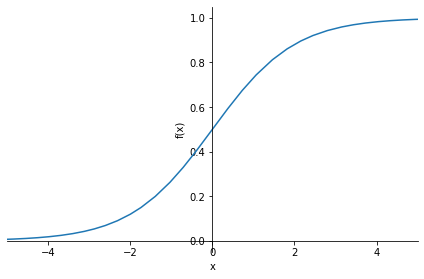

In [108]:
import sympy
sympy.plot("1/(1+exp(-x))", xlim=(-5,5));

### Definindo função de cálculo de predição usando sigmoid e treinando o modelo.

In [109]:
def calc_preds(coeffs, indeps): return torch.sigmoid((indeps*coeffs).sum(axis=1))

In [110]:
coeffs = train_model(lr=100)

0.499; 0.495; 0.492; 0.489; 0.487; 0.485; 0.484; 0.483; 0.482; 0.482; 0.481; 0.481; 0.481; 0.480; 0.480; 0.480; 0.479; 0.479; 0.479; 0.479; 0.479; 0.479; 0.478; 0.478; 0.478; 0.478; 0.478; 0.478; 0.478; 0.478; 

### Houve um aumento, mas talvez não tão significativo que justifique o uso da função sigmoid.

In [111]:
acc(coeffs)

tensor(0.5185)

### Mostrando agora as colunas.

In [112]:
show_coeffs()

{'title': tensor(-1.7750), 'text': tensor(6.5814)}

## Usando produto matricial

### Mostrando cálculos internos para pegar as predições.

In [113]:
(val_indep*coeffs).sum(axis=1)

tensor([ 0.4553,  3.3653,  2.6495,  1.5430,  0.7552,  2.0644, -0.8517,  ...,  3.9007,  4.3586,  4.5489,  1.2599,  1.5383,  3.7986,
         2.9332])

### Replicando mais simplificadamente o cálculo acima.

In [114]:
val_indep@coeffs

tensor([ 0.4553,  3.3653,  2.6495,  1.5430,  0.7552,  2.0644, -0.8517,  ...,  3.9007,  4.3586,  4.5489,  1.2599,  1.5383,  3.7986,
         2.9332])

### Alterando na função de cálculo de predição.

In [115]:
def calc_preds(coeffs, indeps): return torch.sigmoid(indeps@coeffs)

### Transformando coeffs em vetor coluna.

In [116]:
def init_coeffs(): return (torch.rand(n_coeff, 1)*0.1).requires_grad_()

In [117]:
trn_dep = trn_dep[:,None]
val_dep = val_dep[:,None]

### Treinando novamente o modelo.

In [118]:
coeffs = train_model(lr=100)

0.500; 0.496; 0.492; 0.489; 0.487; 0.486; 0.485; 0.484; 0.483; 0.482; 0.482; 0.481; 0.481; 0.481; 0.480; 0.480; 0.480; 0.479; 0.479; 0.479; 0.479; 0.479; 0.479; 0.478; 0.478; 0.478; 0.478; 0.478; 0.478; 0.478; 

### Verificando acurácia.

In [119]:
acc(coeffs)

tensor(0.5193)

## Rede neural

### Criando coeficientes para cada camada. Na primeira camada pegamos as entradas `n_coeff`, e criamos `n_hidden` saídas. Para a segunda camada usamos`n_hidden` entradas e uma única saída.

In [120]:
def init_coeffs(n_hidden=20):
    layer1 = (torch.rand(n_coeff, n_hidden)-0.5)/n_hidden
    layer2 = torch.rand(n_hidden, 1)-0.3
    const = torch.rand(1)[0]
    return layer1.requires_grad_(),layer2.requires_grad_(),const.requires_grad_()

### Tendo os coeficientes, passamos a criação da rede neural.

In [121]:
import torch.nn.functional as F

def calc_preds(coeffs, indeps):
    l1,l2,const = coeffs
    res = F.relu(indeps@l1)
    res = res@l2 + const
    return torch.sigmoid(res)

### Adicionando os coeficientes em loop.

In [122]:
def update_coeffs(coeffs, lr):
    for layer in coeffs:
        layer.sub_(layer.grad * lr)
        layer.grad.zero_()

### Trainando modelo.

In [123]:
coeffs = train_model(lr=1.4)

0.500; 0.499; 0.499; 0.499; 0.499; 0.499; 0.499; 0.499; 0.499; 0.499; 0.499; 0.499; 0.499; 0.498; 0.498; 0.498; 0.498; 0.498; 0.498; 0.498; 0.498; 0.498; 0.498; 0.498; 0.498; 0.498; 0.497; 0.497; 0.497; 0.497; 

In [124]:
coeffs = train_model(lr=20)

0.500; 0.499; 0.498; 0.496; 0.495; 0.494; 0.493; 0.492; 0.490; 0.489; 0.488; 0.487; 0.485; 0.484; 0.483; 0.482; 0.480; 0.479; 0.478; 0.477; 0.476; 0.475; 0.474; 0.473; 0.473; 0.472; 0.471; 0.471; 0.470; 0.470; 

### Verificando acurácia.

In [125]:
acc(coeffs)

tensor(0.5312)

## Deep learning

### Criando coeficientes para cada camada.

In [126]:
def init_coeffs():
    hiddens = [10, 10]  # <-- set this to the size of each hidden layer you want
    sizes = [n_coeff] + hiddens + [1]
    n = len(sizes)
    layers = [(torch.rand(sizes[i], sizes[i+1])-0.3)/sizes[i+1]*4 for i in range(n-1)]
    consts = [(torch.rand(1)[0]-0.5)*0.1 for i in range(n-1)]
    for l in layers+consts: l.requires_grad_()
    return layers,consts

### Alterando `calc_preds` com loop para cada camada ao invés de usá-las separadamente.

In [127]:
import torch.nn.functional as F

def calc_preds(coeffs, indeps):
    layers,consts = coeffs
    n = len(layers)
    res = indeps
    for i,l in enumerate(layers):
        res = res@l + consts[i]
        if i!=n-1: res = F.relu(res)
    return torch.sigmoid(res)

### Atualizando `update_coeffs`já que `layers` and `consts` estão separadas agora.

In [128]:
def update_coeffs(coeffs, lr):
    layers,consts = coeffs
    for layer in layers+consts:
        layer.sub_(layer.grad * lr)
        layer.grad.zero_()

### Treinando o modelo.

In [129]:
coeffs = train_model(lr=4)

0.497; 0.495; 0.495; 0.494; 0.493; 0.493; 0.491; 0.491; 0.493; 0.495; 0.495; 0.494; 0.491; 0.490; 0.495; 0.495; 0.494; 0.491; 0.490; 0.495; 0.495; 0.493; 0.488; 0.493; 0.495; 0.494; 0.490; 0.486; 0.492; 0.485; 

### Verificando acurácia

In [130]:
acc(coeffs)

tensor(0.5375)

## Salvando o modelo para subir para o hugging face

In [137]:
torch.save(coeffs, 'fake-news.pth')